In [44]:
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter

import torch.distributed as dist

In [ ]:
GPU=0

In [46]:
SEED=1

random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = True

scaler = GradScaler()

In [ ]:
torch.cuda.device_count()

In [47]:
START_EPOCH = 0

In [48]:
ARCH = 'resnet18'
EPOCHS = 2
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
PRINT_FREQ = 50
TRAIN_BATCH=2048
VAL_BATCH=2048
WORKERS=2

TRAINDIR="/home/ubuntu/data/train"
VALDIR="/home/ubuntu/data/val"

### Check if cuda is available here

In [49]:
# check if cuda is available in this cell
# if it is not available, you should not go forward!
if not torch.cuda.is_available():
    print("GPU not detected...")

CUDA is available: True


### Create the multi cluster world

In [50]:
WORLD_SIZE = 2
BACKEND = 'nccl'
#where is the master?
URL = 'tcp://34.211.56.224:1234' #ip of master VM

In [51]:
RANK = 0 #this is for the master, use a 1 for the other vm

In [ ]:
dist.init_process_group(backend = BACKEND, init_method = URL, 
                        world_size = WORLD_SIZE, rank = RANK)

In [52]:
torch.cuda.set_device(GPU)
cudnn.benchmark = True

### Fill in the heart of the train section below

In [65]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    ######################
    # switch model to train mode here
    model.train()
    ################

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        #####################
        # send the images to cuda device
        images = images.to(device)
        # send the target to cuda device
        target = target.to(device)

        # compute output
        with autocast():
            output = model(images)

        # compute loss 
        with autocast():
            loss = criterion(output, target)


        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        
        
        
        #### zero out gradients in the optimier
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        ## backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)

#### Fill in the validate section below

In [66]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            
            
            ### send the images and target to cuda
            images = images.cuda()
            target = target.cuda()

            # compute output
            output = model(images)

            # compute loss
            loss = criterion(output, target)


            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

### Save the checkpoint

In [67]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    # save the model state!
    torch.save(state, filename)
    
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [68]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [69]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [70]:
# if we are adjusting the LR manually use this
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [71]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [72]:
imagenet_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
imagenet_std_RGB = [0.24205776, 0.23828046, 0.25874835]

In [73]:
normalize = transforms.Normalize(mean=imagenet_mean_RGB, std=imagenet_std_RGB)

In [74]:
IMG_SIZE = 32
NUM_CLASSES = 10
# IMG_SIZE = 224

### Initialize the model using the architecture you selected above

In [75]:
# select the model
model = models.__dict__[ARCH]()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
inf = model.fc.in_features
model.fc = nn.Linear(inf, NUM_CLASSES)

### Send the model to the cuda device

In [76]:
model.cuda(GPU)
model = torch.nn.parallel.DistributedDataParallel(model, device_ids = [GPU])
model = model.to(device)

### Instantiate the loss to cross entropy

In [77]:
# use the cross-entropy loss
criterion = nn.CrossEntropyLoss().cuda(GPU)

### Instantiate the optimizer to SGD

In [78]:
# use SGD .. use the momentum and weight decay vars
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#### Create the learning rate scheduler

In [79]:
# use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001)

In [81]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cinic_mean_RGB, cinic_std_RGB),
])

### Create the train dataset object

In [83]:
train_dataset = datasets.ImageFolder(root=TRAINDIR, 
                                     transform=transform_train)

In [84]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cinic_mean_RGB, cinic_std_RGB),
])

### Create the val dataset object

In [85]:
# use torchvision.datasets.CIFAR10
# val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
val_dataset = datasets.ImageFolder(root=VALDIR, transform=transform_val)

### Create the train dataloader

In [86]:
# fill this in
train_loader = torch.utils.data.DataLoader(train_dataset, 
                     batch_size=TRAIN_BATCH, 
                     shuffle=True, 
                     num_workers=WORKERS
                     pin_memory=TRUE,
                     sampler=torch.utils.data.distributed.DistributedSampler(train_dataset))

In [87]:
# fill this in..
val_loader = torch.utils.data.DataLoader(val_dataset, 
                            batch_size=VAL_BATCH,
                            shuffle=False, 
                            num_workers=WORKERS,
                            pin_membory=TRUE,
                            sampler=None)

In [89]:
best_acc1 = 0

In [90]:
%%time

# create TensorBoard summary writer
writer = SummaryWriter()

for epoch in range(START_EPOCH, EPOCHS):
#    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)


    if RANK == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': ARCH,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, is_best)
    
    scheduler.step()
    print('lr: ' + str(scheduler.get_last_lr()))
    
    # write to TensorBoard
    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Validation Accuracy', acc1, epoch)
    
# close TensorBoard writer
writer.close()

Epoch: [0][  0/704]	Time  0.620 ( 0.620)	Data  0.586 ( 0.586)	Loss 1.7814e+00 (1.7814e+00)	Acc@1  35.94 ( 35.94)	Acc@5  84.38 ( 84.38)
Epoch: [0][ 50/704]	Time  0.232 ( 0.220)	Data  0.207 ( 0.185)	Loss 1.7582e+00 (1.8286e+00)	Acc@1  32.81 ( 30.70)	Acc@5  86.72 ( 85.55)
Epoch: [0][100/704]	Time  0.101 ( 0.207)	Data  0.068 ( 0.175)	Loss 1.9695e+00 (1.8057e+00)	Acc@1  23.44 ( 31.37)	Acc@5  83.59 ( 86.07)
Epoch: [0][150/704]	Time  0.040 ( 0.205)	Data  0.002 ( 0.171)	Loss 1.6992e+00 (1.7974e+00)	Acc@1  35.16 ( 31.88)	Acc@5  85.94 ( 86.20)
Epoch: [0][200/704]	Time  0.043 ( 0.208)	Data  0.001 ( 0.173)	Loss 1.7987e+00 (1.7864e+00)	Acc@1  29.69 ( 32.44)	Acc@5  82.81 ( 86.26)
Epoch: [0][250/704]	Time  0.047 ( 0.208)	Data  0.002 ( 0.172)	Loss 1.6315e+00 (1.7794e+00)	Acc@1  40.62 ( 32.85)	Acc@5  91.41 ( 86.34)
Epoch: [0][300/704]	Time  0.066 ( 0.206)	Data  0.001 ( 0.170)	Loss 1.7643e+00 (1.7735e+00)	Acc@1  37.50 ( 33.16)	Acc@5  89.06 ( 86.57)
Epoch: [0][350/704]	Time  0.048 ( 0.206)	Data  0.001 ( 

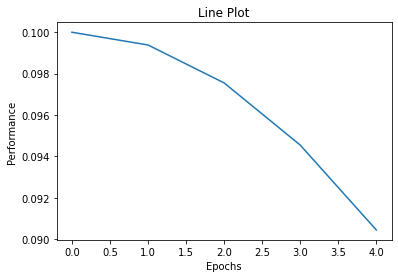

In [91]:
import matplotlib.pyplot as plt

plt.plot(epochs, results)
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Line Plot')
plt.show()